In [5]:
library(tidyverse)
library(grid)
library(gridExtra)

source("../../evaluation_utils/plots_eda.R")
source("../../evaluation_utils/filtering.R")

# MODE

In [6]:
# MODE <- 'balanced'
MODE <- 'imbalanced'

## Load data

In [7]:
path_to_data <- paste0("/home/yuliya/repos/other/removeBatch/evaluation_data/proteomics/before/", MODE, "/")

metadata <- read.csv(paste0(path_to_data, "central_batch_info.tsv"), sep = "\t") %>%
    column_to_rownames('rowname') %>% 
    as.data.frame() %>%
    mutate(file = gsub("X", "", file))
dim(metadata)

intensities <- read.csv(paste0(path_to_data, "central_intensities.tsv"), sep = "\t", row.names = 1)
# change X in the beginning of the column names to empty string
colnames(intensities) <- gsub("X", "", colnames(intensities))
colnames(intensities) <- gsub("\\.", "-", colnames(intensities))
intensities <- intensities %>% as.data.frame()

dim(intensities)
intensities_raw <- intensities[, metadata$file]
intensities <- log2(intensities_raw)

write.table(intensities %>% rownames_to_column("Protein"), file = paste0(path_to_data, "central_intensities_log.tsv"), sep = "\t", quote = F, row.names = F)

[1] 73  3

[1] 3058   73

In [8]:
intensities_filteres <- filter_per_center(intensities, metadata, 'file', unique(metadata$lab), 'lab')

# save before
write.table(intensities_filteres %>% rownames_to_column("Protein"), 
    file = paste0(path_to_data, "central_intensities_log_filtered.tsv"), sep = "\t", quote = F, row.names = F, col.names = T)


Filtering by center - two not-NA per center
	Before filtering: 3058 73 
	After filtering: 2272 73 


In [9]:
for(center in unique(metadata$lab)){
    center_metadata <- metadata[metadata$lab == center,]
    center_intensities <- intensities_raw[, center_metadata$file]
    center_intensities_filtered <- intensities_filteres[, center_metadata$file]

    path_before <- paste(path_to_data, center, "/", sep = "")

    if(!dir.exists(path_before)){
        dir.create(path_before)
    }
    write.table(center_intensities %>% rownames_to_column('rowname'), 
        file = paste0(path_before, "intensities_raw.tsv"), sep = "\t", quote = F, row.names = F, col.names = T)
    write.table(center_metadata,
        file = paste0(path_before, "metadata.tsv"), sep = "\t", quote = F, row.names = F, col.names = T)
    write.table(center_intensities_filtered %>% rownames_to_column('rowname'),
        file = paste0(path_before, "intensities_log_filtered.tsv"), sep = "\t", quote = F, row.names = F, col.names = T)
}



Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


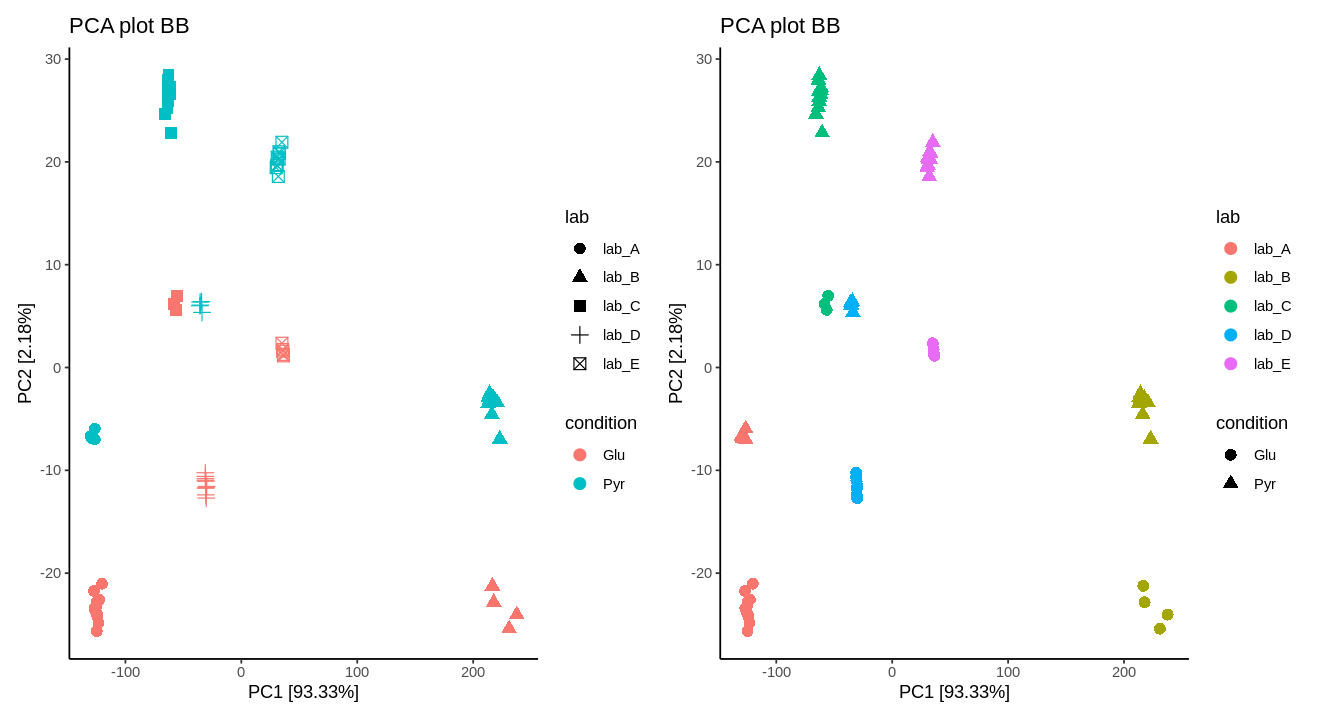

In [10]:
pca_plot_study <- pca_plot(
    intensities_filteres, metadata, 
    title = "PCA plot BB",
    quantitative_col_name = 'file',
    col_col = "lab", shape_col = "condition")

pca_plot_class <- pca_plot(
    intensities_filteres, metadata, 
    title = "PCA plot BB",
    quantitative_col_name = 'file',
    shape_col = "lab", col_col = "condition")

layout <- (pca_plot_class | pca_plot_study)
options(repr.plot.width=11, repr.plot.height=6)
layout

In [11]:
# create design
metadata <- metadata %>%
    mutate(condition = factor(condition, levels = c("Glu", "Pyr")))
design= model.matrix(~condition, data = metadata)
colnames(design) <- c("Intercept", "Pyr")

intensities_corrected <- limma::removeBatchEffect(intensities_filteres, metadata$lab, design = design) %>% as.data.frame()


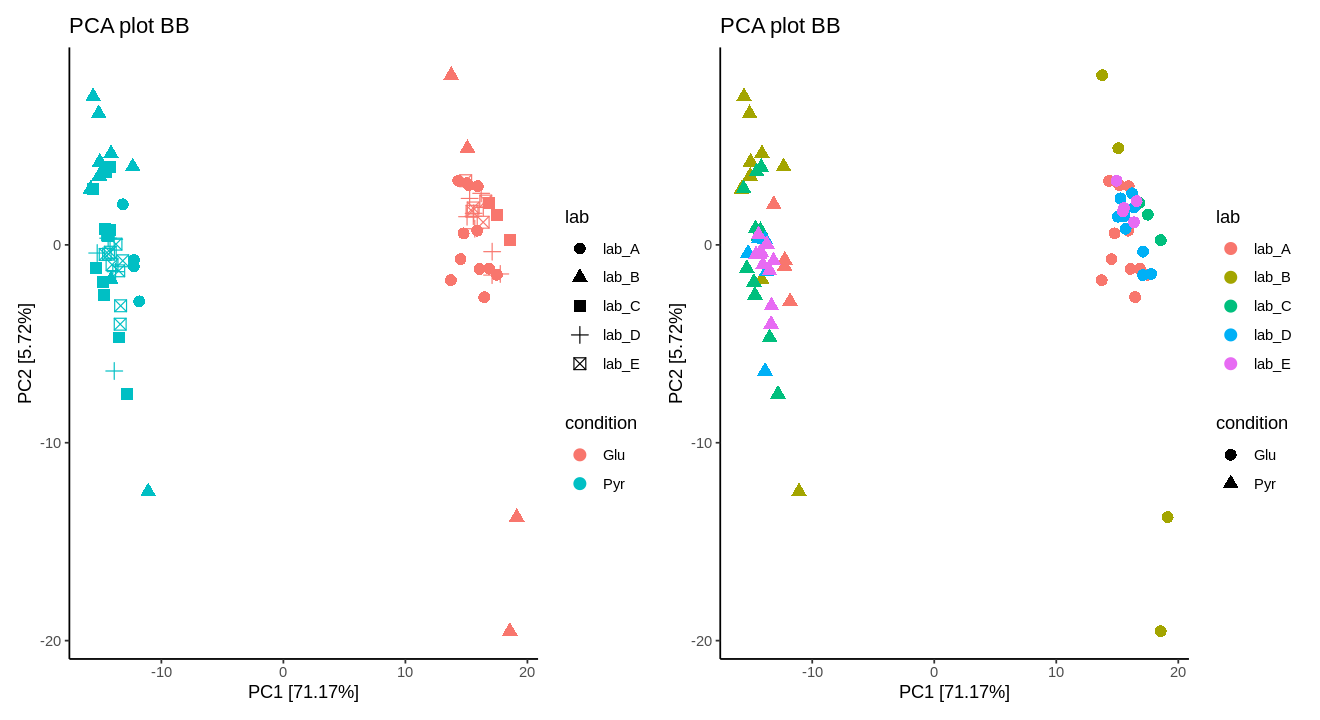

In [12]:
pca_plot_study <- pca_plot(
    intensities_corrected, metadata, 
    title = "PCA plot BB",
    quantitative_col_name = 'file',
    col_col = "lab", shape_col = "condition")

pca_plot_class <- pca_plot(
    intensities_corrected, metadata, 
    title = "PCA plot BB",
    quantitative_col_name = 'file',
    shape_col = "lab", col_col = "condition")

layout <- (pca_plot_class | pca_plot_study)
options(repr.plot.width=11, repr.plot.height=6)
layout

In [13]:
design <- design %>% as.data.frame()
path_to_after_data <- paste0("/home/yuliya/repos/other/removeBatch/evaluation_data/proteomics/after/", MODE, "/")


for(center in unique(metadata$lab)){
    path_to_before <- paste0(path_to_data, center, "/")
    path_to_after <- paste0("/home/yuliya/repos/other/removeBatch/evaluation_data/proteomics/after/", MODE, "/", center, "/")

    design_center = design[rownames(metadata[metadata$lab == center,]),]['Pyr']

    # if(!dir.exists(path_to_after)){
    #     dir.create(path_to_after)
    # }

    write.table(design_center %>% rownames_to_column('file'),
        file = paste0(path_to_before, "design.tsv"), sep = "\t", quote = F, row.names = F, col.names = T)
}

write.table(intensities_corrected %>% rownames_to_column('rowname'), 
    file = paste0(path_to_after_data, "central_intensities_log_filtered_corrected.tsv"), sep = "\t", quote = F, row.names = F, col.names = T)
write.table(metadata,
    file = paste0(path_to_after_data, "central_batch_info_corrected.tsv"), sep = "\t", quote = F, row.names = F, col.names = T)